# Production Model

Here we are trying to train a model and export it for inference purpose.
We can use that model in a production enviroment. (via CPU)


In [1]:
from fastai2.vision.all import *
from fastai2.vision.widgets import *
from utils import *

## Configure the Data Path

Change the following section as needed based your setup.

In [2]:
data_path = Path('../data')
synth_images_path = data_path/"synths"

## Bing Image Search

For this we are going to use Bing Image Search.
Which has a good FREE tier.

In [3]:
bing_image_search_key="06b8097bcdaa46b3b65312dbae563891"

In [4]:
result = search_images_bing(bing_image_search_key, 'Digitakt')

In [5]:
urls = result.attrgot('content_url')
dest = "/tmp/digitakt1.jpg"
download_url(urls[0], dest)

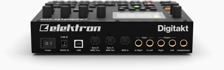

In [6]:
img = Image.open(dest)
img.to_thumb(224, 224)

## Download Images to Train

Here we are downloading some images for three types of synths I love.

In [7]:
synth_types = 'Digitakt', 'teenage engineering opz', 'Moog Grandmother'

In [8]:
if not synth_images_path.exists():
    synth_images_path.mkdir()
    for synth_type in synth_types:
        dest = (synth_images_path/synth_type)
        dest.mkdir(exist_ok=True)
        image_result = search_images_bing(bing_image_search_key, synth_type)
        download_images(dest, urls=image_result.attrgot('content_url'))

In [9]:
image_paths = get_image_files(synth_images_path)
image_paths

(#427) [Path('../data/synths/teenage engineering opz/00000062.jpg'),Path('../data/synths/teenage engineering opz/00000009.jpg'),Path('../data/synths/teenage engineering opz/00000130.jpg'),Path('../data/synths/teenage engineering opz/00000021.jpg'),Path('../data/synths/teenage engineering opz/00000090.jpg'),Path('../data/synths/teenage engineering opz/00000074.jpg'),Path('../data/synths/teenage engineering opz/00000028.jpg'),Path('../data/synths/teenage engineering opz/00000026.jpg'),Path('../data/synths/teenage engineering opz/00000056.jpg'),Path('../data/synths/teenage engineering opz/00000069.jpg')...]

In [10]:
## We need to find out failed downloads and clean them.
## So, they don't affect our model
failed_downloads = verify_images(image_paths)
failed_downloads

(#0) []

In [11]:
failed_downloads.map(Path.unlink)

(#0) []

## Create Data Loaders from the Images

To train our model, we need to convert our images into the data loaders. For that, we use the `DataBlock` API.

In [12]:
synths_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
)

In [13]:
synths_dls = synths_db.dataloaders(synth_images_path)

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


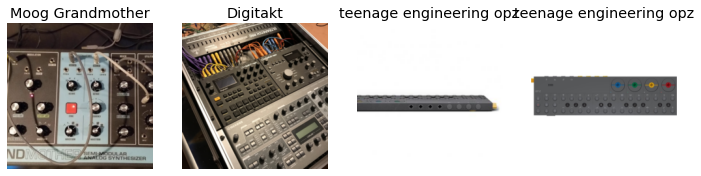

In [14]:
synths_dls.train.show_batch(max_n=4, nrows=1)

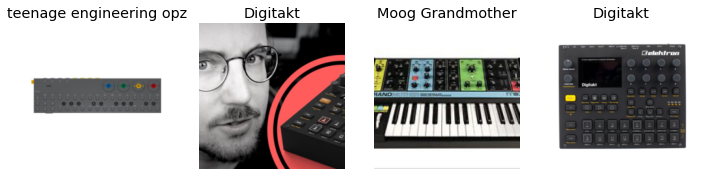

In [15]:
synths_dls.valid.show_batch(max_n=4, nrows=1)

## Let's Starting Learning

In [16]:
learn = cnn_learner(synths_dls, resnet34, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.475402,0.406114,0.176471,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.553930,0.277164,0.105882,00:06
1,0.380510,0.232433,0.094118,00:07
2,0.276356,0.265244,0.070588,00:06
3,0.207078,0.287794,0.082353,00:07
4,0.161955,0.296727,0.082353,00:06
5,0.132837,0.292687,0.082353,00:06


## Visualize the Result

We need to see how our model performed. Let's have a look

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

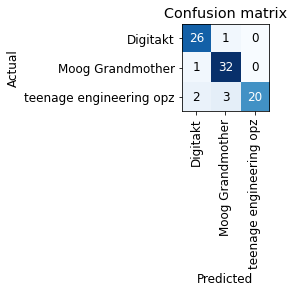

In [18]:
interp.plot_confusion_matrix()

All looks fine. Let's check these worst cases. May be they are wrong images may be.

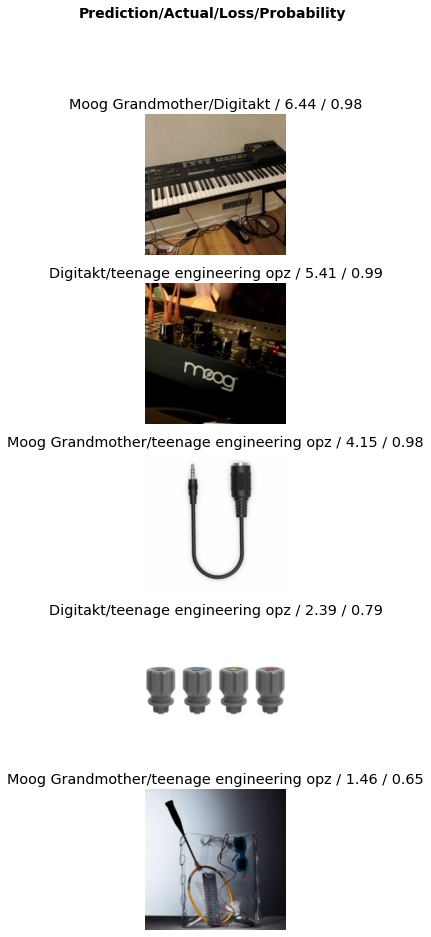

In [19]:
interp.plot_top_losses(5, nrows=5)

As you can see, those are pretty strange images. It's really impressive that they can see identify some of those correctly.

## Export the Model

In [20]:
learn.export("synths.pkl")

In [21]:
cwd = Path()
cwd.ls()

(#9) [Path('.gitignore'),Path('synths.pkl'),Path('utils.py'),Path('.git'),Path('01-intro.ipynb'),Path('.ipynb_checkpoints'),Path('02-production.ipynb'),Path('push.sh'),Path('__pycache__')]

## Inferencing

Inferencing is the way to predict based on the model we generated. Usually we do this via the CPU.
It's not useufl to do this inside a GPU.

In [22]:
learn_inf = load_learner("synths.pkl")

In [23]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

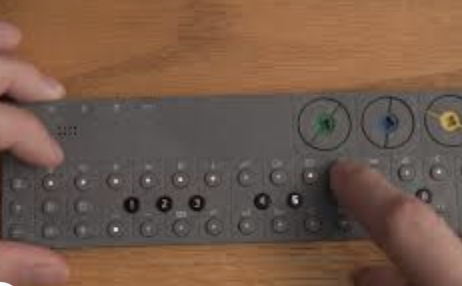

In [25]:
uploaded_image = PILImage.create(uploader.data[0])
uploaded_image

In [27]:
learn_inf.predict(uploaded_image)

('teenage engineering opz', tensor(2), tensor([0.0052, 0.0019, 0.9929]))